# Homework Starter — Stage 08 EDA

Fill in the marked TODOs. This notebook generates synthetic data so you can focus on the EDA flow. Replace with your dataset when ready.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)

# === Synthetic data generator (adapt or replace with your own data) ===
n = 160
df = pd.DataFrame({
    'date': pd.date_range('2021-02-01', periods=n, freq='D'),
    'region': np.random.choice(['North','South','East','West'], size=n),
    'age': np.random.normal(40, 8, size=n).clip(22, 70).round(1),
    'income': np.random.lognormal(mean=10.6, sigma=0.3, size=n).round(2),
    'transactions': np.random.poisson(lam=3, size=n),
})
base = df['income'] * 0.0015 + df['transactions']*18 + np.random.normal(0, 40, size=n)
df['spend'] = np.maximum(0, base).round(2)

# inject a bit of missingness and outliers
df.loc[np.random.choice(df.index, 5, replace=False), 'income'] = np.nan
df.loc[np.random.choice(df.index, 3, replace=False), 'spend'] = np.nan
df.loc[np.random.choice(df.index, 2, replace=False), 'transactions'] = df['transactions'].max()+12
df.head()

,date,region,age,income,transactions,spend
0,2021-02-01,West,37.6,28086.81,4,73.35
1,2021-02-02,North,43.0,33034.75,1,52.37
2,2021-02-03,South,38.2,50045.39,2,131.85
3,2021-02-04,South,24.9,39467.28,4,147.58
4,2021-02-05,South,59.8,31201.65,1,86.76


In [2]:
from pathlib import Path
PROCESSED_DIR = Path('../data/processed')
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

## 1) First look

In [3]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          160 non-null    datetime64[ns]
 1   region        160 non-null    object        
 2   age           160 non-null    float64       
 3   income        155 non-null    float64       
 4   transactions  160 non-null    int32         
 5   spend         157 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int32(1), object(1)
memory usage: 7.0+ KB


(None,
 date            0
 region          0
 age             0
 income          5
 transactions    0
 spend           3
 dtype: int64)

In [4]:
missing_tbl = df.isna().sum().to_frame('missing')
missing_tbl['pct'] = (missing_tbl['missing'] / len(df)).round(3)
display(missing_tbl)
missing_tbl.to_csv(PROCESSED_DIR / 'eda_missing_counts.csv')

,missing,pct
date,0,0.000
region,0,0.000
age,0,0.000
income,5,0.031
transactions,0,0.000
spend,3,0.019


## 2) Numeric profile

In [5]:
desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,160.0,40.018750,8.458676,22.00,34.70,40.15,44.925,61.10,0.069538,-0.080125
income,155.0,41983.866323,13262.457038,17928.80,32471.53,39332.52,49697.690,87052.40,0.993336,0.918722
transactions,160.0,3.237500,2.585610,0.00,2.00,3.00,4.000,20.00,3.466078,19.984802
spend,157.0,117.291592,51.768645,0.54,77.25,119.32,153.340,280.05,0.130860,-0.084917


In [6]:
desc_rounded = desc.copy()
for col in ['mean','std','min','25%','50%','75%','max','skew','kurtosis']:
    if col in desc_rounded:
        desc_rounded[col] = desc_rounded[col].round(3)
display(desc_rounded)
desc_rounded.to_csv(PROCESSED_DIR / 'eda_numeric_profile.csv')

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,160.0,40.019,8.459,22.00,34.70,40.15,44.925,61.10,0.070,-0.080
income,155.0,41983.866,13262.457,17928.80,32471.53,39332.52,49697.690,87052.40,0.993,0.919
transactions,160.0,3.238,2.586,0.00,2.00,3.00,4.000,20.00,3.466,19.985
spend,157.0,117.292,51.769,0.54,77.25,119.32,153.340,280.05,0.131,-0.085


{'categorical_columns': ['region']}

,count,pct
region,,
West,47,0.294
East,42,0.262
South,36,0.225
North,35,0.219


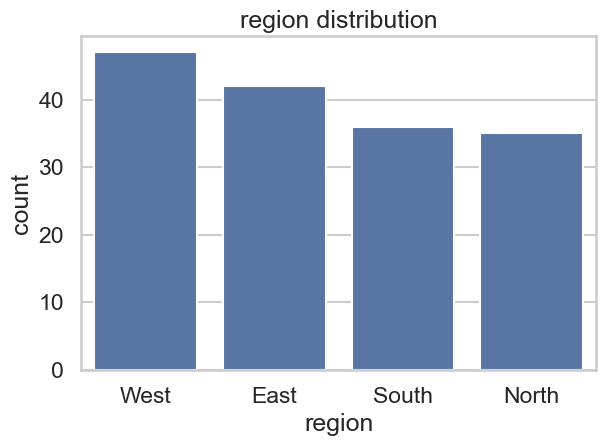

In [7]:
## 2b) Categorical profile
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
display({'categorical_columns': cat_cols})

for c in cat_cols:
    vc = df[c].value_counts(dropna=False).rename_axis(c).to_frame('count')
    vc['pct'] = (vc['count'] / len(df)).round(3)
    display(vc)
    vc.to_csv(PROCESSED_DIR / f'eda_value_counts_{c}.csv')

    # quick bar plot
    plt.figure()
    sns.countplot(x=c, data=df, order=df[c].value_counts().index)
    plt.title(f'{c} distribution')
    plt.xlabel(c); plt.ylabel('count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(PROCESSED_DIR / f'plot_bar_{c}.png', dpi=150)
    plt.show()

## 3) Distributions (TODO: add at least 3)

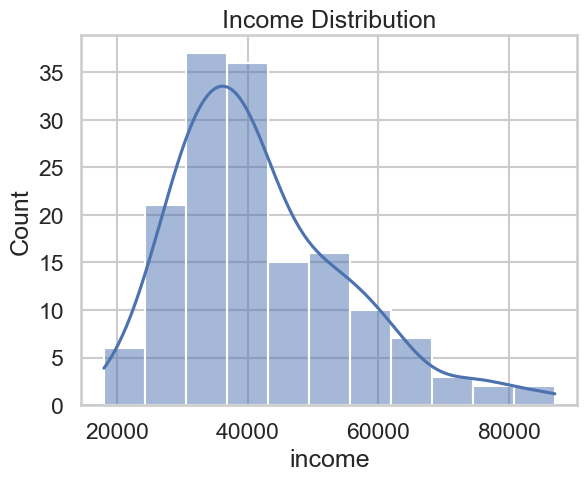

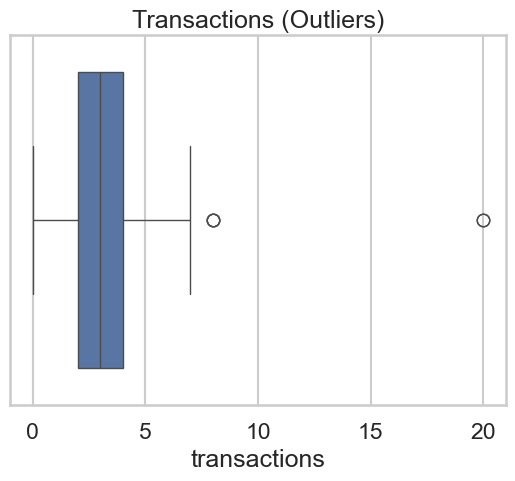

In [8]:
# TODO: histogram + KDE for a key variable
sns.histplot(df['income'], kde=True)
plt.title('Income Distribution')
plt.show()

# TODO: boxplot for outliers
sns.boxplot(x=df['transactions'])
plt.title('Transactions (Outliers)')
plt.show()

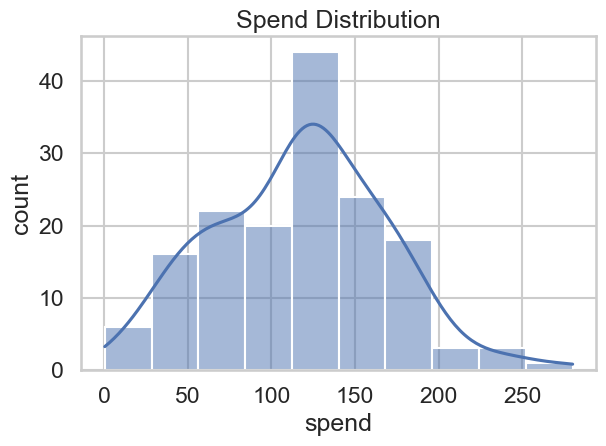

In [9]:
sns.histplot(df['spend'], kde=True)
plt.title('Spend Distribution')
plt.xlabel('spend'); plt.ylabel('count')
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'plot_hist_spend.png', dpi=150)
plt.show()

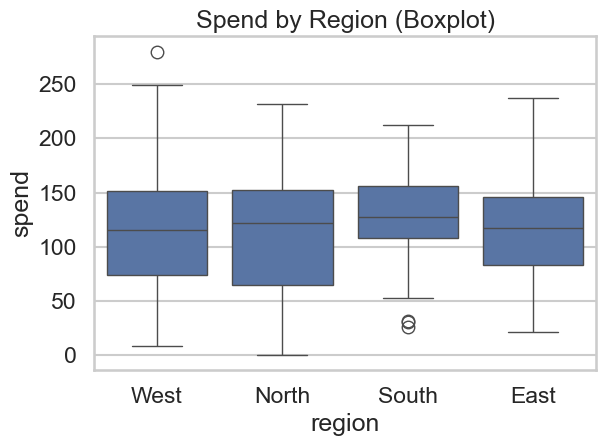

In [10]:
sns.boxplot(data=df, x='region', y='spend')
plt.title('Spend by Region (Boxplot)')
plt.xlabel('region'); plt.ylabel('spend')
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'plot_box_spend_by_region.png', dpi=150)
plt.show()

## 4) Relationships (TODO: add at least 2)

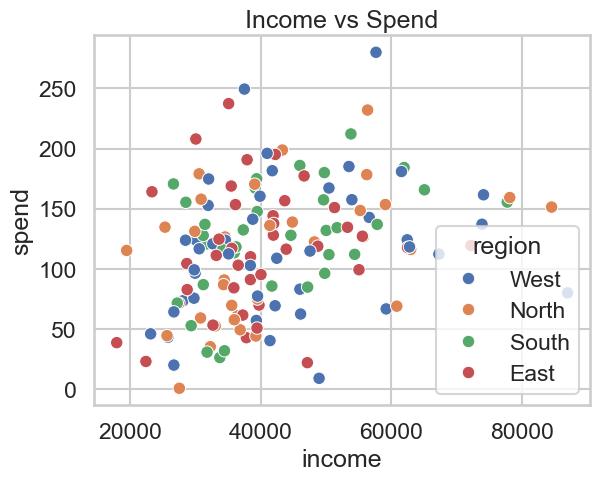

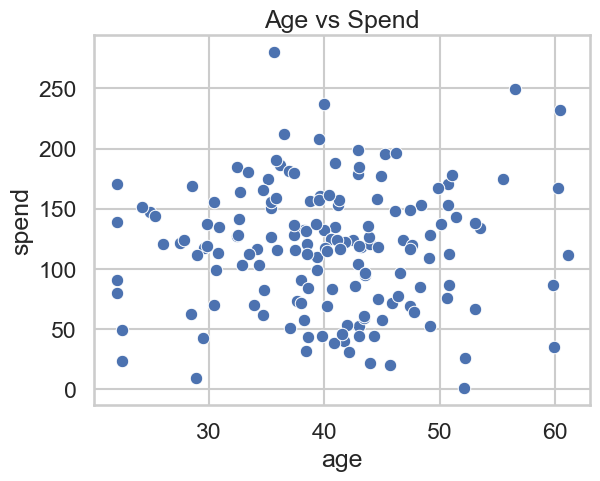

In [11]:
sns.scatterplot(data=df, x='income', y='spend', hue='region')
plt.title('Income vs Spend')
plt.show()

sns.scatterplot(data=df, x='age', y='spend')
plt.title('Age vs Spend')
plt.show()

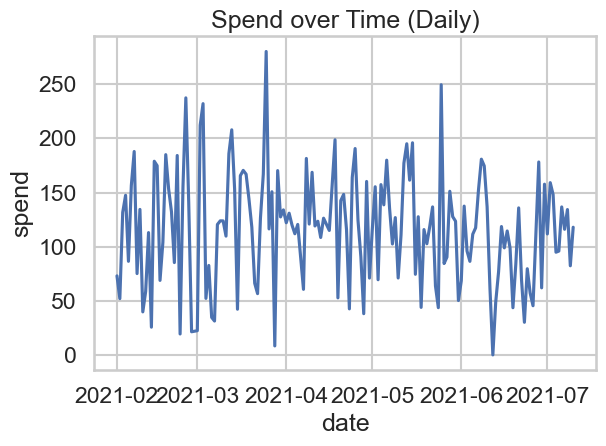

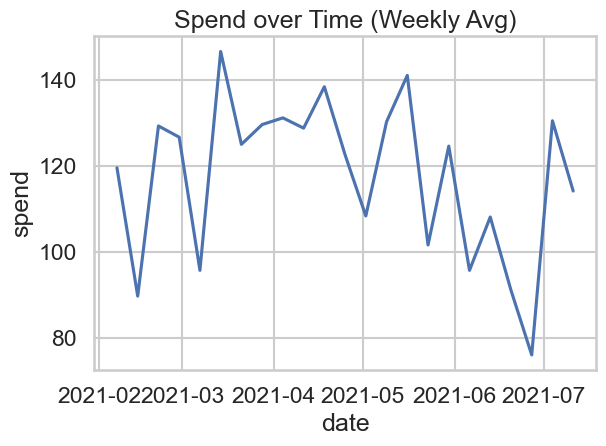

In [12]:
# Time trend: spend over time (daily and weekly avg)
# Daily line (may be noisy)
sns.lineplot(data=df.sort_values('date'), x='date', y='spend')
plt.title('Spend over Time (Daily)')
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'plot_line_spend_daily.png', dpi=150)
plt.show()

# Weekly average (smoother)
df_week = df.set_index('date').resample('W')['spend'].mean().reset_index()
sns.lineplot(data=df_week, x='date', y='spend')
plt.title('Spend over Time (Weekly Avg)')
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'plot_line_spend_weekly.png', dpi=150)
plt.show()

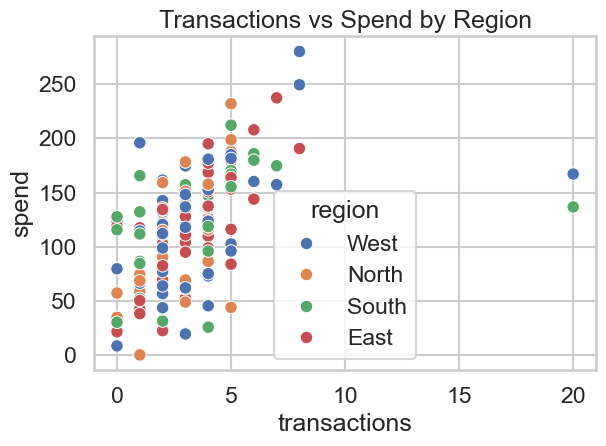

In [13]:
sns.scatterplot(data=df, x='transactions', y='spend', hue='region')
plt.title('Transactions vs Spend by Region')
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'plot_scatter_txn_spend_by_region.png', dpi=150)
plt.show()

## 5) (Optional) Correlation matrix

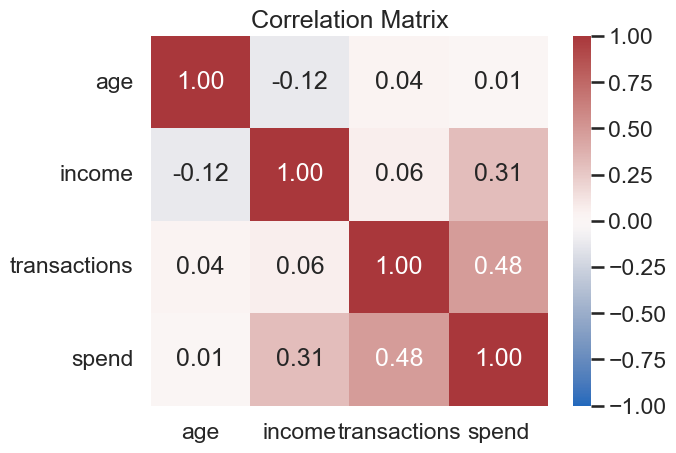

,age,income,transactions,spend
age,1.000000,-0.123160,0.037754,0.008174
income,-0.123160,1.000000,0.063573,0.307307
transactions,0.037754,0.063573,1.000000,0.480685
spend,0.008174,0.307307,0.480685,1.000000


In [14]:
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

In [15]:
corr.round(3).to_csv(PROCESSED_DIR / 'eda_correlation_matrix.csv')

## 6) Insights & Assumptions (write your commentary)
- TODO: Top 3 insights
- TODO: Assumptions & risks
- TODO: Next steps before modeling (cleaning & features)

**Top 3 insights**
1) Income is right-skewed. Using log(income) will stabilize variance for models.
2) Spend correlates positively with income and transactions (see corr heatmap and scatterplots).
3) There is mild weekly seasonality in spend (weekly average line plot shows fluctuations).

**Assumptions & risks**
- Synthetic data approximates our target schema; real data may have different skew/outlier patterns.
- Missingness appears low/moderate; assuming missing at random may be wrong.
- Region effects seem present; risk of confounding if regions correlate with unmodeled factors.

**Next steps before modeling**
- Impute missing income/spend (median or model-based); consider log(income).
- Engineer features: transactions per week, spend rolling means, region dummies.
- Winsorize or robust-scale highly skewed variables; try interaction (income × transactions).